# About

This notebook utilizes Natural Language Processing to classifiy whether tweets are about a disaster or not.

Data taken from Kaggle - Natural Language Processing with Disaster Tweets

In [0]:

import os
import sys

sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

!pip install pip --upgrade
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install tensorflow

sys.stdout = sys.__stdout__
sys.stderr = sys.__stderr__

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [0]:
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from pyspark.sql.types import BooleanType, StringType, ArrayType, StructType, StructField, DoubleType
import re
import string

from pyspark.sql.functions import col, udf, lower, split, when

from nltk.corpus import stopwords, words
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, ne_chunk

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, VectorAssembler, CountVectorizer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [0]:
train_file_path = "default.nlp_train_8_csv"
test_file_path = "default.nlp_test_6_csv"

In [0]:
# Load data and remove the nulls
train_df = spark.table(train_file_path).filter(col('text').isNotNull()).filter(col('target').isNotNull())
test_df = spark.table(test_file_path).filter(col('text').isNotNull())

In [0]:
display(train_df.limit(20))

id,keyword,location,text,target
1,null,null,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4,null,null,Forest fire near La Ronge Sask. Canada,1
5,null,null,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
6,null,null,"13,000 people receive #wildfires evacuation orders in California",1
7,null,null,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
8,null,null,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
10,null,null,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
13,null,null,I'm on top of the hill and I can see a fire in the woods...,1
14,null,null,There's an emergency evacuation happening now in the building across the street,1
15,null,null,I'm afraid that the tornado is coming to our area...,1


In [0]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

# Initialize stopwords, lemmatizer, and word list
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
word_list = set(words.words())

# Broadcast stopwords and word list
broadcast_stop_words = spark.sparkContext.broadcast(stop_words)
broadcast_word_list = spark.sparkContext.broadcast(word_list)

# Clean Data

In [0]:
class data_cleaning():
    def __init__(self, broadcast_stop_words, broadcast_word_list):
        self.stop_words = broadcast_stop_words.value
        self.lemmatizer = WordNetLemmatizer()
        self.word_list = broadcast_word_list.value
    
    def contains_url(self, text):
        url_pattern = re.compile(r'http[s]?://')
        return bool(url_pattern.search(text))
    
    def remove_urls(self, text):
        url_pattern = re.compile(r'http[s]?://\S+')
        return url_pattern.sub('', text)
    
    # Remove the pound sign from the hashtags, but find the words within the hashtag
    def split_hashtag(self, hashtag):
        def segment(text, word_list):
            n = len(text)
            dp = [None] * (n + 1)
            dp[0] = []
            for i in range(1, n + 1):
                for j in range(i):
                    word = text[j:i].lower()
                    if word in word_list and dp[j] is not None:
                        if dp[i] is None or len(dp[j]) + 1 < len(dp[i]):
                            dp[i] = dp[j] + [word]
            return dp[-1] if dp[-1] is not None else [text]

        words = hashtag.split()
        result = []
        for word in words:
            if word.startswith("#"):
                word = word[1:]
                split_words_in_tag = segment(word, self.word_list)
                result.append(" ".join(split_words_in_tag))
            else:
                result.append(word)
        return " ".join(result)

    def process_text(self, text):
        hashtag_pattern = re.compile(r'#\w+')
        hashtags = hashtag_pattern.findall(text)
        text = hashtag_pattern.sub('', text)
        processed_hashtags = " ".join([self.split_hashtag(tag) for tag in hashtags])
        return text + " " + processed_hashtags
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    def remove_stopwords(self, text):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in self.stop_words]
        return ' '.join(filtered_words)
    
    # Prepare data for logistic regression
    
    def lemmatize_tokens(self, tokens):
        return [self.lemmatizer.lemmatize(token) for token in tokens]

    def pos_tag_tokens(self, tokens):
        return pos_tag(tokens)

    def clean(self, df):
        contains_url_udf = udf(self.contains_url, BooleanType())
        remove_urls_udf = udf(self.remove_urls, StringType())
        process_text_udf = udf(self.process_text, StringType())
        remove_punctuation_udf = udf(self.remove_punctuation, StringType())
        remove_stopwords_udf = udf(self.remove_stopwords, StringType())
        lemmatize_tokens_udf = udf(self.lemmatize_tokens, ArrayType(StringType()))

        pos_tag_schema = ArrayType(StructType([
            StructField("word", StringType(), False),
            StructField("pos", StringType(), False)
        ]))

        pos_tag_tokens_udf = udf(self.pos_tag_tokens, pos_tag_schema)

        # Create a flag column for if a row contains a url
        df = df.withColumn("contains_url", contains_url_udf(col("text")))

        # Remove urls from the text
        df = df.withColumn("text", remove_urls_udf(col("text")))

        # Remove the pound sign from hashtags, but split the hashtag into words within the hashtags
        df = df.withColumn("text", process_text_udf(col("text")))

        # Convert all letters to lowercase
        df = df.withColumn("text", lower(col("text")))

        # Remove punctuation from the text
        df = df.withColumn("text", remove_punctuation_udf(col("text")))

        # Remove all words that don't add importance
        df = df.withColumn("text", remove_stopwords_udf(col("text")))

        # Turn the text into arrays of words
        df = df.withColumn("token", split(col("text"), " "))

        # Break words down with lemmatization
        df = df.withColumn("token", lemmatize_tokens_udf(col("token")))

        # Tag the parts of speech
        df = df.withColumn("pos_tag", pos_tag_tokens_udf(col("token")))
        return df

In [0]:
class MLPipeline:
    def __init__(self):
        self.tokenizer = Tokenizer(inputCol="text", outputCol="words")
        self.vectorizer = CountVectorizer(inputCol="words", outputCol="raw_features")
        self.idf = IDF(inputCol="raw_features", outputCol="features")
        self.indexer = StringIndexer(inputCol="target", outputCol="label")
        self.lr = LogisticRegression(featuresCol="features", labelCol="label")
        self.pipeline = Pipeline(stages=[self.tokenizer, self.vectorizer, self.idf, self.indexer, self.lr])
        self.model = None

    def train_and_evaluate(self, df):
        train_df, test_df = df.randomSplit([0.8, 0.2], seed=12345)

        # Hyperparameter Tuning
        paramGrid = ParamGridBuilder().addGrid(self.vectorizer.vocabSize, [1000, 5000, 10000]).addGrid(self.lr.regParam, [0.1, 0.01]).build()

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

        # Cross Validation
        crossval = CrossValidator(estimator=self.pipeline,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=evaluator,
                                  numFolds=3,
                                  parallelism=2)

        spark.conf.set("spark.databricks.widget.display", "false")

        self.model = crossval.fit(train_df)
        predictions = self.model.transform(test_df)

        # Evaluate
        accuracy = evaluator.evaluate(predictions)
        print(f"Cross-validated accuracy: {accuracy}")

        self.display_confusion_matrix(predictions)

        self.display_top_words()
        return self.model

    def predict(self, df):
        if self.model is None:
            raise ValueError("Model is not trained. Call train_and_evaluate first.")
        predictions = self.model.transform(df)
        return predictions
    
    def display_confusion_matrix(self, predictions):
        pandas_df = predictions.select("label", "prediction").toPandas()

        y_true = pandas_df["label"]
        y_pred = pandas_df["prediction"]
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix Heatmap")
        plt.show()
        
    def display_top_words(self):
        # Extract feature importances
        coefficients = self.model.bestModel.stages[-1].coefficients.toArray()
        vocab = self.model.bestModel.stages[1].vocabulary

        word_coefficients = [(vocab[i], coefficients[i]) for i in range(len(vocab))]
        word_coefficients = sorted(word_coefficients, key=lambda x: x[1], reverse=True)

        print("Top words associated with target=1:")
        for word, coef in word_coefficients[:10]:
            print(f"{word}: {coef}")

id,keyword,location,text,target,contains_url,token,pos_tag
1,null,null,deeds reason may allah forgive us earthquake,1,false,"List(deed, reason, may, allah, forgive, u, earthquake)","List(List(deed, VB), List(reason, NN), List(may, MD), List(allah, VB), List(forgive, JJ), List(u, JJ), List(earthquake, NN))"
4,null,null,forest fire near la ronge sask canada,1,false,"List(forest, fire, near, la, ronge, sask, canada)","List(List(forest, JJS), List(fire, NN), List(near, IN), List(la, JJ), List(ronge, NN), List(sask, NN), List(canada, NN))"
5,null,null,residents asked shelter place notified officers evacuation shelter place orders expected,1,false,"List(resident, asked, shelter, place, notified, officer, evacuation, shelter, place, order, expected)","List(List(resident, NN), List(asked, VBD), List(shelter, JJ), List(place, NN), List(notified, JJ), List(officer, NN), List(evacuation, NN), List(shelter, NN), List(place, NN), List(order, NN), List(expected, VBD))"
6,null,null,13000 people receive evacuation orders california wildfire,1,false,"List(13000, people, receive, evacuation, order, california, wildfire)","List(List(13000, CD), List(people, NNS), List(receive, JJ), List(evacuation, NN), List(order, NN), List(california, NN), List(wildfire, NN))"
7,null,null,got sent photo ruby smoke pours school alas ka wildfire,1,false,"List(got, sent, photo, ruby, smoke, pours, school, ala, ka, wildfire)","List(List(got, VBD), List(sent, JJ), List(photo, NN), List(ruby, NN), List(smoke, NN), List(pours, VBZ), List(school, NN), List(ala, NN), List(ka, NN), List(wildfire, NN))"
8,null,null,update california hwy 20 closed directions due lake county fire rocky fire c afire wildfire,1,false,"List(update, california, hwy, 20, closed, direction, due, lake, county, fire, rocky, fire, c, afire, wildfire)","List(List(update, JJ), List(california, NN), List(hwy, NN), List(20, CD), List(closed, JJ), List(direction, NN), List(due, JJ), List(lake, VBP), List(county, JJ), List(fire, NN), List(rocky, JJ), List(fire, NN), List(c, NN), List(afire, NN), List(wildfire, NN))"
10,null,null,heavy rain causes flash flooding streets manitou colorado springs areas flood disaster,1,false,"List(heavy, rain, cause, flash, flooding, street, manitou, colorado, spring, area, flood, disaster)","List(List(heavy, JJ), List(rain, NN), List(cause, NN), List(flash, NN), List(flooding, VBG), List(street, NN), List(manitou, NNS), List(colorado, VBP), List(spring, NN), List(area, NN), List(flood, NN), List(disaster, NN))"
13,null,null,im top hill see fire woods,1,false,"List(im, top, hill, see, fire, wood)","List(List(im, NN), List(top, NN), List(hill, NN), List(see, VBP), List(fire, NN), List(wood, NN))"
14,null,null,theres emergency evacuation happening building across street,1,false,"List(there, emergency, evacuation, happening, building, across, street)","List(List(there, RB), List(emergency, NN), List(evacuation, NN), List(happening, VBG), List(building, NN), List(across, IN), List(street, NN))"
15,null,null,im afraid tornado coming area,1,false,"List(im, afraid, tornado, coming, area)","List(List(im, NN), List(afraid, JJ), List(tornado, NN), List(coming, VBG), List(area, NN))"


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

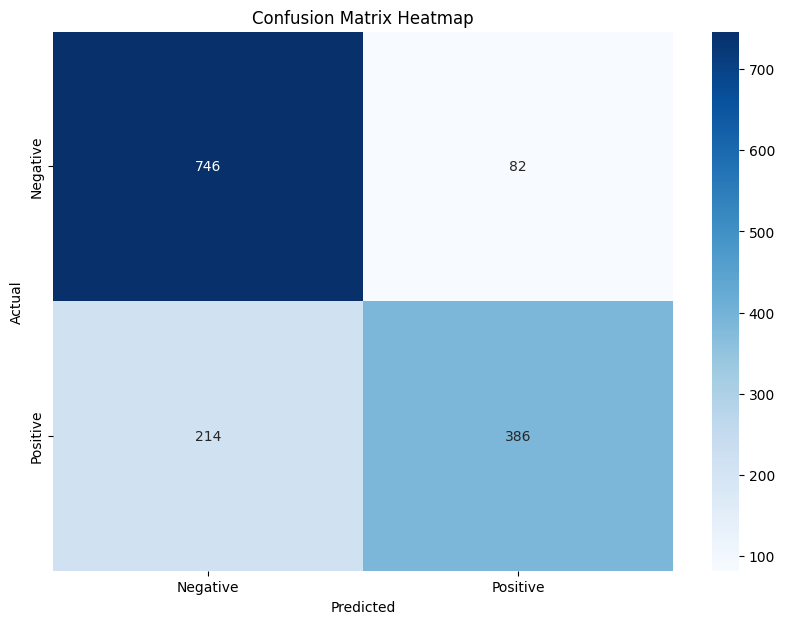

Cross-validated accuracy: 0.7927170868347339
Top words associated with target=1:
typhoon: 0.28372028363533985
earthquake: 0.25531091412629103
evacuated: 0.24637390725287062
derailment: 0.23643637796405498
bombing: 0.2357077340159286
fires: 0.2331462612123163
wildfire: 0.23005589459353892
hiroshima: 0.22915260377900765
poor: 0.22824856896042237
casualties: 0.22399488037028473


In [0]:
cleaner = data_cleaning(broadcast_stop_words, broadcast_word_list)
ml_pipeline = MLPipeline()

# Clean the data
cleaned_train_df = cleaner.clean(train_df)
cleaned_test_df = cleaner.clean(test_df)

display(cleaned_train_df.limit(20))

model = ml_pipeline.train_and_evaluate(cleaned_train_df)

In [0]:
# predictions = ml_pipeline.predict(cleaned_test_df)

# predictions_final = predictions.withColumnRenamed('prediction', 'target').select('id', 'target')
# display(predictions_final)